## Importing Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras
from keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from keras import Model
from tensorflow.keras import activations
import warnings
warnings.filterwarnings("ignore")
import nltk.translate.bleu_score as bleu

In [10]:
from google.colab import drive 
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
os.chdir("/content/drive/MyDrive/Capstone/Medical Report Generation Using Deeplearning") 

## Fetching the cleaned dataset

In [13]:
df_new = pd.read_csv('/content/drive/MyDrive/Capstone/Medical-report-generation/final_df.csv')

In [14]:
df_new.head()

,image1,image2,impression,images
0,CXR3677_IM-1830-1001.png,CXR3677_IM-1830-2001.png,Heart size is within normal limits Aorta is to...,"CXR3677_IM-1830-1001.png,CXR3677_IM-1830-2001.png"
1,CXR3687_IM-1838-2001.png,CXR3687_IM-1838-1001.png,Heart size and mediastinal contours are within...,"CXR3687_IM-1838-2001.png,CXR3687_IM-1838-1001.png"
2,CXR3695_IM-1845-1001.png,CXR3695_IM-1845-2001.png,The cardiac silhouette size is at the upper li...,"CXR3695_IM-1845-1001.png,CXR3695_IM-1845-2001.png"
3,CXR3699_IM-1846-1002.png,CXR3699_IM-1846-1001.png,Normal heart size mediastinal contours No foca...,"CXR3699_IM-1846-1002.png,CXR3699_IM-1846-1001.png"
4,CXR3685_IM-1836-1002.png,CXR3685_IM-1836-1001.png,Calcified thoracic aorta Mild rightward deviat...,"CXR3685_IM-1836-1002.png,CXR3685_IM-1836-1001.png"


In [15]:
df_new.shape


(3514, 4)

## Cleaning text 

In [16]:
import re
def decontraction(phrase):
# specific
  phrase = re.sub(r"won\ 't","will not", phrase)
  phrase = re.sub(r"can\ 't","can not", phrase)
# general
  phrase = re.sub(r"n\'t"," not", phrase)
  phrase = re.sub(r"'\re"," are", phrase)
  phrase = re.sub(r"\'s"," is",phrase)
  phrase = re.sub(r"\'d"," would",phrase)
  phrase = re.sub(r"\'ll"," will",phrase)
  phrase = re.sub(r"\'t"," not",phrase)
  phrase = re.sub(r"\'ve"," have",phrase)
  phrase = re.sub(r"\'m"," am",phrase)
  return phrase

In [17]:
for i in tqdm(range(0,df_new.shape [0])):
  text = re.sub(r'(\s\d+)', "", df_new.iloc[i]. loc['impression'])
  text = text.lower ()
  text = re.sub(r'[^a-z]',' ',text)
  text = text.strip("")
  text = decontraction(text)
  df_new.iloc[i].loc['impression'] = text

100%|██████████| 3514/3514 [00:00<00:00, 4885.09it/s]


In [18]:
for i in tqdm(range(0,df_new.shape [0])):
  text = re.sub(r'\b\w{,1/\b','',df_new.iloc[i].loc['impression'])
  text = text.strip(" ")
  df_new.iloc[i].loc['impression']= re.sub(r'\s\s+'," ", text)

100%|██████████| 3514/3514 [00:00<00:00, 5374.61it/s]


In [19]:
df_new.head()

,image1,image2,impression,images
0,CXR3677_IM-1830-1001.png,CXR3677_IM-1830-2001.png,heart size is within normal limits aorta is to...,"CXR3677_IM-1830-1001.png,CXR3677_IM-1830-2001.png"
1,CXR3687_IM-1838-2001.png,CXR3687_IM-1838-1001.png,heart size and mediastinal contours are within...,"CXR3687_IM-1838-2001.png,CXR3687_IM-1838-1001.png"
2,CXR3695_IM-1845-1001.png,CXR3695_IM-1845-2001.png,the cardiac silhouette size is at the upper li...,"CXR3695_IM-1845-1001.png,CXR3695_IM-1845-2001.png"
3,CXR3699_IM-1846-1002.png,CXR3699_IM-1846-1001.png,normal heart size mediastinal contours no foca...,"CXR3699_IM-1846-1002.png,CXR3699_IM-1846-1001.png"
4,CXR3685_IM-1836-1002.png,CXR3685_IM-1836-1001.png,calcified thoracic aorta mild rightward deviat...,"CXR3685_IM-1836-1002.png,CXR3685_IM-1836-1001.png"


## Preparing the text by adding 'start' and 'end' to the text

In [20]:
df = df_new.copy()

In [21]:
for i in tqdm(range (0,df .shape [0])):
  df.iloc[i]['image 1'] = f"./{df.iloc[i]['image1']}.png"
  df.iloc[i]['image 2'] = f"./{df.iloc[i] ['image2']}.png"
  df.iloc[i]['impression'] = f"<start> {df.iloc[i]['impression'].strip()} <end>"
  

100%|██████████| 3514/3514 [00:04<00:00, 825.80it/s]


In [22]:
df.head ()

,image1,image2,impression,images
0,CXR3677_IM-1830-1001.png,CXR3677_IM-1830-2001.png,<start> heart size is within normal limits aor...,"CXR3677_IM-1830-1001.png,CXR3677_IM-1830-2001.png"
1,CXR3687_IM-1838-2001.png,CXR3687_IM-1838-1001.png,<start> heart size and mediastinal contours ar...,"CXR3687_IM-1838-2001.png,CXR3687_IM-1838-1001.png"
2,CXR3695_IM-1845-1001.png,CXR3695_IM-1845-2001.png,<start> the cardiac silhouette size is at the ...,"CXR3695_IM-1845-1001.png,CXR3695_IM-1845-2001.png"
3,CXR3699_IM-1846-1002.png,CXR3699_IM-1846-1001.png,<start> normal heart size mediastinal contours...,"CXR3699_IM-1846-1002.png,CXR3699_IM-1846-1001.png"
4,CXR3685_IM-1836-1002.png,CXR3685_IM-1836-1001.png,<start> calcified thoracic aorta mild rightwar...,"CXR3685_IM-1836-1002.png,CXR3685_IM-1836-1001.png"


In [23]:
df.shape, df_new.shape

((3514, 4), (3514, 4))

In [24]:
df.head()

,image1,image2,impression,images
0,CXR3677_IM-1830-1001.png,CXR3677_IM-1830-2001.png,<start> heart size is within normal limits aor...,"CXR3677_IM-1830-1001.png,CXR3677_IM-1830-2001.png"
1,CXR3687_IM-1838-2001.png,CXR3687_IM-1838-1001.png,<start> heart size and mediastinal contours ar...,"CXR3687_IM-1838-2001.png,CXR3687_IM-1838-1001.png"
2,CXR3695_IM-1845-1001.png,CXR3695_IM-1845-2001.png,<start> the cardiac silhouette size is at the ...,"CXR3695_IM-1845-1001.png,CXR3695_IM-1845-2001.png"
3,CXR3699_IM-1846-1002.png,CXR3699_IM-1846-1001.png,<start> normal heart size mediastinal contours...,"CXR3699_IM-1846-1002.png,CXR3699_IM-1846-1001.png"
4,CXR3685_IM-1836-1002.png,CXR3685_IM-1836-1001.png,<start> calcified thoracic aorta mild rightwar...,"CXR3685_IM-1836-1002.png,CXR3685_IM-1836-1001.png"


In [25]:

df['image1'] = df['image1'].apply(lambda x: "{}{}".format('/content/drive/MyDrive/Capstone/Medical Report Generation Using Deeplearning/NLMCXR_png/', x))
df['image2'] = df['image2'].apply(lambda x: "{}{}".format('/content/drive/MyDrive/Capstone/Medical Report Generation Using Deeplearning/NLMCXR_png/', x))

In [26]:
df['image1'][0]

'/content/drive/MyDrive/Capstone/Medical Report Generation Using Deeplearning/NLMCXR_png/CXR3677_IM-1830-1001.png'

In [27]:
med_report = []
image_path = []
for i in tqdm(range (0,df.shape [0])):
  image_path.append(df.iloc[i].loc['image1'])
  med_report.append(df.iloc[i].loc['impression'])
  image_path.append(df.iloc[i].loc['image2'])
  med_report.append(df.iloc[i].loc['impression'])


100%|██████████| 3514/3514 [00:00<00:00, 4059.90it/s]


In [28]:
train_captions = []
image_paths = []
train_captions = med_report
image_paths = image_path

##  Initialize DenseNet121 and loading pretrained CheXNet weights

In [29]:
chexnet_weights="/content/drive/MyDrive/Capstone/Medical Report Generation Using Deeplearning/brucechou1983_CheXNet_Keras_0.3.0_weights.h5"
image_model = tf.keras.applications.densenet.DenseNet121(include_top=True, classes=14,weights=chexnet_weights)
new_input = image_model.input
hidden_layer = image_model. layers [-3].output
image_features_extract_model = tf.keras.Model(new_input,hidden_layer)
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [30]:
# Function to read the image, decode and resize to (224,224).
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img,(224, 224))
  img = tf.keras.applications.densenet.preprocess_input(img)
  return img, image_path



## Creating Dataset and extracting features from images

In [32]:
# Get unique images
encode_train = sorted(set(image_paths))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  # for bf, p in zip(batch_features, path):
  #   path_of_feature = p.numpy().decode("utf-8")
  #   np.save(path_of_feature, bf.numpy())

100%|██████████| 405/405 [1:38:48<00:00, 14.64s/it]


## Tokenizing the text data

In [33]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# Max word count for a caption.
max_length = 100
vocabulary_size = 12000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [34]:
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [35]:
## Create mappring for word to tokens and tokens to words 
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Split data to training and testing in 80-20

In [36]:
## Split data to training and testing in 80-20
import collections
import random
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_paths, cap_vector):
  img_to_cap_vector[img].append(cap)


img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [37]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(5643, 5643, 1385, 1385)

## Creating  dataset for training 

In [38]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 512
units = 1024
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2560
#attention_features_shape = 64
attention_features_shape = 49

In [39]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [40]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))>

## Modeling - using Encoder, Decoder, and Attention models.


The encoder model takes the extracted features and passed the features through the fully connected layer and then applies RELU activation function.
The attention model returns context_vector and attention_weights. It will be used in the decoder. In the decoder model , there is a Embedding layer, one GRU layer, and two dense layers.The decoder model returns decoder output, decoder state and attention_weights.

In [42]:
class Attention(tf.keras.Model):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):

    hidden_with_time_axis = tf.expand_dims(hidden, 1)


    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))


    # this helps to give unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)


    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [43]:
class CNN_Encoder(tf.keras.Model):
    # We will use already extracted the features 
    # This encoder passes those extracted features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [44]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = Attention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

## Training the model 

In [45]:
# created the encoder and decoder objects
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [46]:
#  optimizer as Adam and loss_object as SparseCategoricalCrossentropy
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [47]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                            decoder=decoder,
                            optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [48]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
   start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
   # restoring the latest checkpoint in checkpoint_path
   ckpt.restore(ckpt_manager.latest_checkpoint)

In [49]:
loss_plot = []

In [50]:
# this is tensor function.
#The extracted feature i.e image tensor is passed to encoder.
# decoder returns the predictions used to calculate loss and the decoder’s hidden state

@tf.function
def train_step(img_tensor, target):
  loss = 0


  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # pass the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

  
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [51]:
EPOCHS = 15

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 4 Batch 0 Loss 0.6659
Epoch 4 Loss 0.609986
Time taken for 1 epoch 259.73 sec

Epoch 5 Batch 0 Loss 0.6393
Epoch 5 Loss 0.594413
Time taken for 1 epoch 59.43 sec

Epoch 6 Batch 0 Loss 0.5644
Epoch 6 Loss 0.579095
Time taken for 1 epoch 60.73 sec

Epoch 7 Batch 0 Loss 0.6021
Epoch 7 Loss 0.567914
Time taken for 1 epoch 61.11 sec

Epoch 8 Batch 0 Loss 0.6277
Epoch 8 Loss 0.556749
Time taken for 1 epoch 61.42 sec

Epoch 9 Batch 0 Loss 0.5252
Epoch 9 Loss 0.545288
Time taken for 1 epoch 61.49 sec

Epoch 10 Batch 0 Loss 0.6136
Epoch 10 Loss 0.538117
Time taken for 1 epoch 61.47 sec

Epoch 11 Batch 0 Loss 0.5192
Epoch 11 Loss 0.525848
Time taken for 1 epoch 61.80 sec

Epoch 12 Batch 0 Loss 0.5307
Epoch 12 Loss 0.511823
Time taken for 1 epoch 61.50 sec

Epoch 13 Batch 0 Loss 0.4865
Epoch 13 Loss 0.504570
Time taken for 1 epoch 61.49 sec

Epoch 14 Batch 0 Loss 0.4649
Epoch 14 Loss 0.495936
Time taken for 1 epoch 61.43 sec

Epoch 15 Batch 0 Loss 0.4944
Epoch 15 Loss 0.483024
Time taken fo

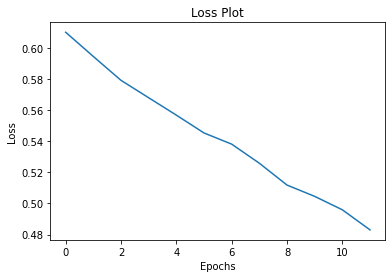

In [52]:
# plot the loss
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [53]:
temp_input = tf.expand_dims(load_image('/content/drive/MyDrive/Capstone/Medical Report Generation Using Deeplearning/NLMCXR_png/CXR2957_IM-1354-1003.png')[0], 0)
temp_input

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[-1.7456235 , -1.655124  , -1.4255457 ],
         [-1.9461977 , -1.8601753 , -1.6296856 ],
         [-2.037547  , -1.9535636 , -1.7226589 ],
         ...,
         [-2.0665298 , -1.9831933 , -1.7521569 ],
         [-2.031797  , -1.9476851 , -1.7168065 ],
         [-2.012739  , -1.9282017 , -1.6974097 ]],

        [[-1.975874  , -1.8905139 , -1.6598893 ],
         [-2.112285  , -2.0299697 , -1.7987255 ],
         [-2.117904  , -2.0357141 , -1.8044444 ],
         ...,
         [-2.0665298 , -1.9831933 , -1.7521569 ],
         [-2.0623603 , -1.9789307 , -1.7479132 ],
         [-2.031147  , -1.9470206 , -1.716145  ]],

        [[-1.9491029 , -1.8631452 , -1.6326424 ],
         [-2.0971096 , -2.0144558 , -1.7832804 ],
         [-2.117904  , -2.0357141 , -1.8044444 ],
         ...,
         [-2.070199  , -1.9869443 , -1.7558913 ],
         [-2.0481815 , -1.9644355 , -1.7334825 ],
         [-2.0151556 , -1.9306722 , -1.6998693

## Evaluation and Results

In [54]:
def evaluate(image):

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())


        

        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [55]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(200, 200))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (80, 80))
        grid_size = max(int(np.ceil(len_result/2)), 1)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    # plt.tight_layout()
    plt.show()

rid 261
Real Caption: start normal heart size clear lungs multilevel degenerative disc disease with mild dextrocurvature near the thoracolumbar junction end
Prediction Caption: both lungs are clear and expanded heart and mediastinum of normal size and configuration pulmonary vascularity is within normal limits for size and contour degenerative changes from previous aortic atherosclerotic vascular calcification there is bilateral reticulonodular pattern there are no focal air space opacity no acute osseous abnormality identified visualized osseous structures appear intact end end end end end end and tapering of the cardiomediastinal silhouette and mediastinum size and mediastinal contours are normal there is no pleural effusion or pneumothorax is seen arthritic changes of the aortic no focal air space opacity to suggest a pneumonia there is a


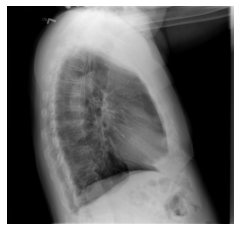

In [56]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
img = plt.imread(image)
plt.figure()
plt.imshow(img, cmap = "gray")
plt.axis(False)
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
# plot_attention(image, result, attention_plot)

The model is giving decent reports for the chest X-ray images.

BLEU Score

In [57]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

chencherry = SmoothingFunction()


In [58]:
index=len(img_name_val)
cols = ['image', 'real','pred','blue']
dat = pd.DataFrame(columns = cols)
bl=0
df_predicted_res = pd.DataFrame()
for j in range(10):
  # captions on the validation se
  # rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[j]
  real_caption = [tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[j] if i not in [0]]
  
  result, attention_plot = evaluate(image)

  rem = ['startseq', 'start', 'end', 'endseq']
  real_caption  = [x for x in real_caption if x not in rem]
  result  = [x for x in result if x not in rem]
  
  print('Real cap: ', ' '.join([i for i in real_caption]))
  print('Predicted cap: ', ' '.join(result))
  
  chencherry = SmoothingFunction()
  bl+=sentence_bleu([result], real_caption,weights=(0, 1, 0, 0), smoothing_function=chencherry.method5)
  print(bl)
  real_cap =  ' '.join([i for i in real_caption])
  pred_cap = ' '.join(result)
  dat = dat.append({'image': image, 'real':real_cap,'pred':pred_cap,'blue':bl},ignore_index=True)
  print('*'*100)
  # bl+=sentence_bleu(real_caption,result)
print("average bleu score on the test data is ",bl/50)

Real cap:  the lungs are clear heart size is normal no pneumothorax there are endplate changes within the spine
Predicted cap:  frontal and lateral views of the lungs appear clear there is no focal airspace consolidation or effusion or infiltrate pleural effusion or pneumothoraces the thoracic aorta and mediastinal contour are noted there is a right sided the prior cholecystectomy there are sternotomy and unfolding of the thoracic aorta is mildly enlarged with history of fracture deformity of the spine or less pericardial effusion at the thoracic spine or
0.016188932361445956
****************************************************************************************************
Real cap:  the lungs are clear heart size is normal no pneumothorax there are endplate changes within the spine
Predicted cap:  pa and lateral views of the chest show normal size is not prominence which could represent with bronchovascular crowding within the left anterior chest the cardiac contours are within norm